# SYST1059A – Capstone Project: Business and Advanced Analytics

## Predictive Analytics for Oil Well Failures: A Machine Learning Approach

## Modeling Analysis Report

By: Titilola Oduwole and Jahir Gutierrez

Date: June 11, 2024

### 1. Outline¶

- Data Loading & Preprocessing
- Handling Imbalanced Data
- Feature Engineering SelectKBest(), RFE and PCA
- Data Splitting (Training / Testing / Validation)
- Data Modeling: Decision Tree
- Benchmark
- Visualization Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

In [2]:
#Loading dataset
file_path = r'C:\Users\jaarg\OneDrive\College_NBCC\6. Spring term_2024\Capstone Project\Databases\03. Cleaned Database\ML Well Failures Prediction.csv'
data = pd.read_csv(file_path)

In [3]:
# Data Overview
print(data.head())
print(data.info())
print(data.describe())

  Well Name  START_DATE Artificial Lift System  Well Intervention Type  \
0    015216  2014-01-04                    PCP                       0   
1    015216  2014-01-08                    PCP                       0   
2    015216  2014-01-09                    PCP                       0   
3    015216  2014-01-10                    PCP                       0   
4    015216  2014-01-11                    PCP                       0   

   Oil rate (bls)  Gas rate (scf)  Water rate (bls)  Total fluid rate (bls)  \
0          122.24            0.98            259.76                   382.0   
1           84.48            0.00            171.52                   256.0   
2           96.40            6.17            385.60                   482.0   
3            0.00            0.00              0.00                     0.0   
4           85.12            1.00            362.88                   448.0   

   Active String?  Fluid Level (ft)  ...  THP (psi)  BSW (%)  Chlorides (ppm)  \

In [4]:
# Converting Artificial Lift System as a numerical variable

In [5]:
count_esp_before = data['Artificial Lift System'].value_counts().get('ESP', 0)
print(f" 'ESP' before One-Hot Encoding: {count_esp_before}")

 'ESP' before One-Hot Encoding: 53585


In [6]:
# Applying One-Hot to Artificial Lift Systems (ESP and ROD & PCP)

data['Artificial_Lift_Type'] = data['Artificial Lift System']

# Grouping as ESP and ROD and PCP (No rods needed vs rod string needed)
data['Artificial Lift System'] = data['Artificial Lift System'].replace({'ROD': 'ROD_PCP', 'PCP': 'ROD_PCP'})
one_hot_encoded = pd.get_dummies(data['Artificial Lift System'], prefix='Lift_System')

data['Artificial Lift System'] = data['Artificial Lift System'].map({'ESP': 1, 'ROD_PCP': 0})

data = pd.concat([data, one_hot_encoded], axis=1)
data.drop(columns=['Lift_System_ESP', 'Lift_System_ROD_PCP'], inplace=True)

In [7]:
count_esp_after = data['Artificial Lift System'].value_counts().get(1, 0)
print(f"'ESP' before One-Hot Encoding: {count_esp_after}")

'ESP' before One-Hot Encoding: 53585


In [8]:
# Checking the new columns
print(data.head())
print(data.info())
print(data.describe())
data.keys()

  Well Name  START_DATE  Artificial Lift System  Well Intervention Type  \
0    015216  2014-01-04                       0                       0   
1    015216  2014-01-08                       0                       0   
2    015216  2014-01-09                       0                       0   
3    015216  2014-01-10                       0                       0   
4    015216  2014-01-11                       0                       0   

   Oil rate (bls)  Gas rate (scf)  Water rate (bls)  Total fluid rate (bls)  \
0          122.24            0.98            259.76                   382.0   
1           84.48            0.00            171.52                   256.0   
2           96.40            6.17            385.60                   482.0   
3            0.00            0.00              0.00                     0.0   
4           85.12            1.00            362.88                   448.0   

   Active String?  Fluid Level (ft)  ...  BSW (%)  Chlorides (ppm)  \
0   

Index(['Well Name', 'START_DATE', 'Artificial Lift System',
       'Well Intervention Type', 'Oil rate (bls)', 'Gas rate (scf)',
       'Water rate (bls)', 'Total fluid rate (bls)', 'Active String?',
       'Fluid Level (ft)', 'Pump Intake (ft)', 'CHP (psi)', 'THP (psi)',
       'BSW (%)', 'Chlorides (ppm)', 'Stop Date', 'Run Life (days)',
       'Intervention Category', 'Rift Subsystem', 'Rift Component Primary',
       'Rift Cause General', 'String Status', 'Artificial_Lift_Type'],
      dtype='object')

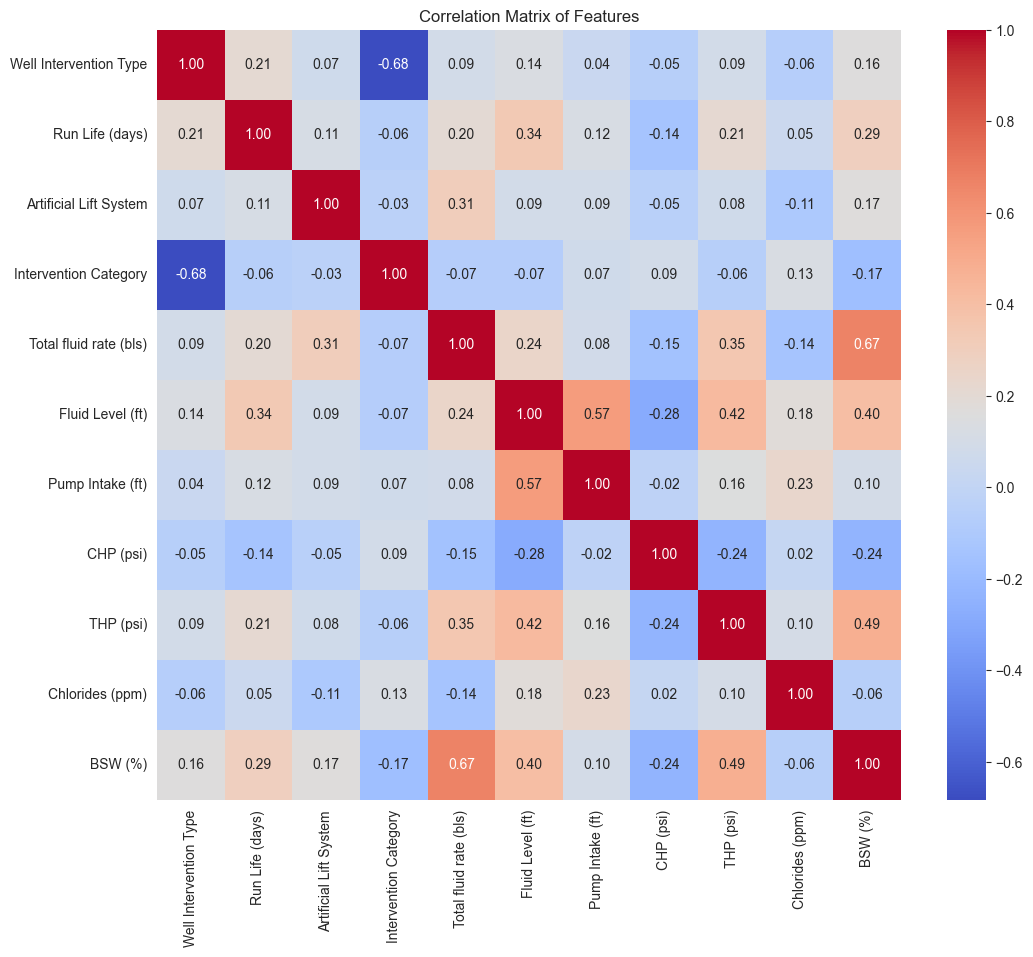

In [9]:
# Calculating the correlation matrix
corr_matrix = data[['Well Intervention Type', 'Run Life (days)', 'Artificial Lift System', 'Intervention Category', 'Total fluid rate (bls)', 'Fluid Level (ft)', 'Pump Intake (ft)', 'CHP (psi)', 'THP (psi)', 'Chlorides (ppm)', 'BSW (%)']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

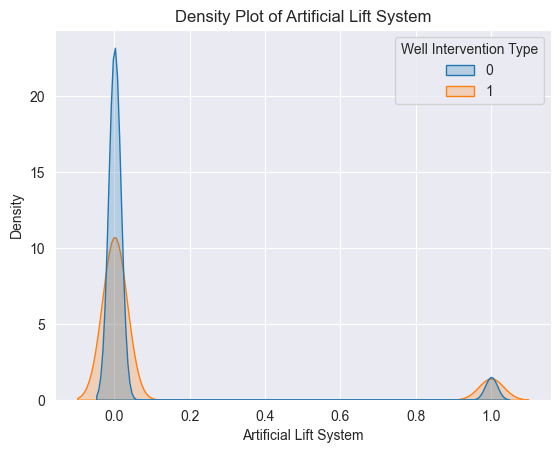

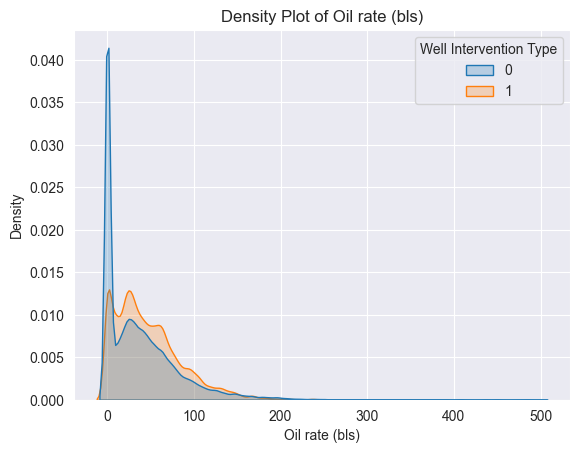

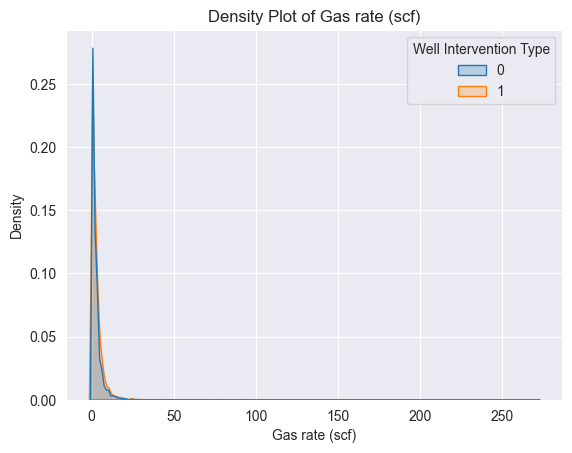

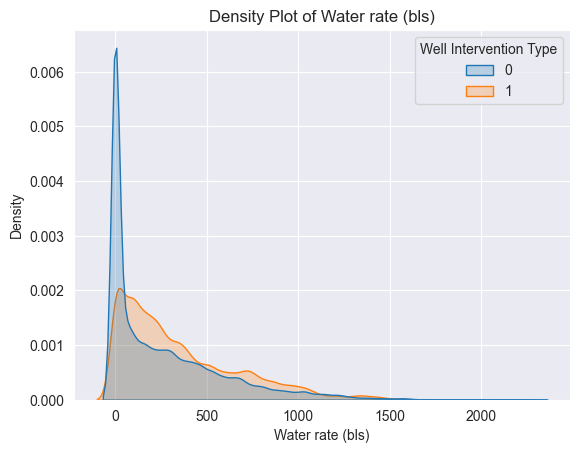

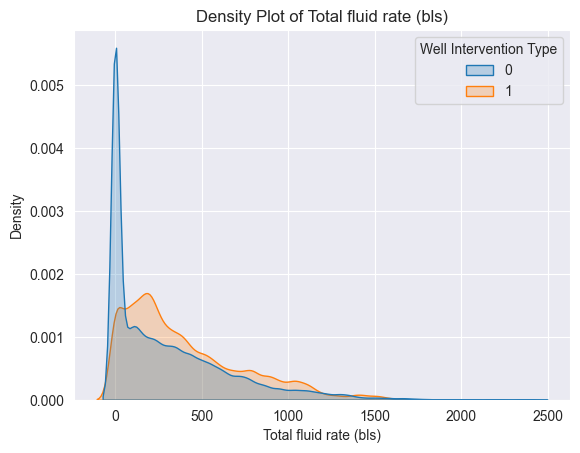

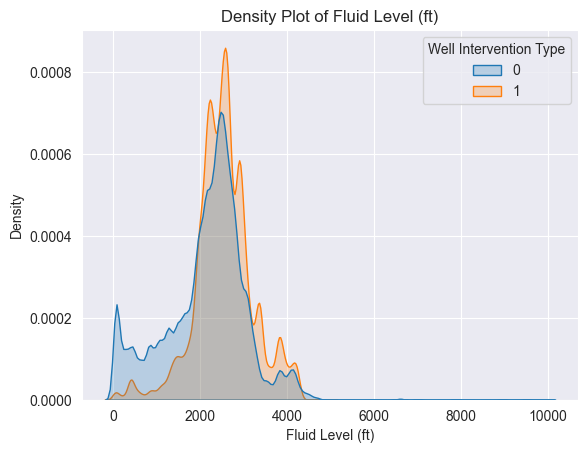

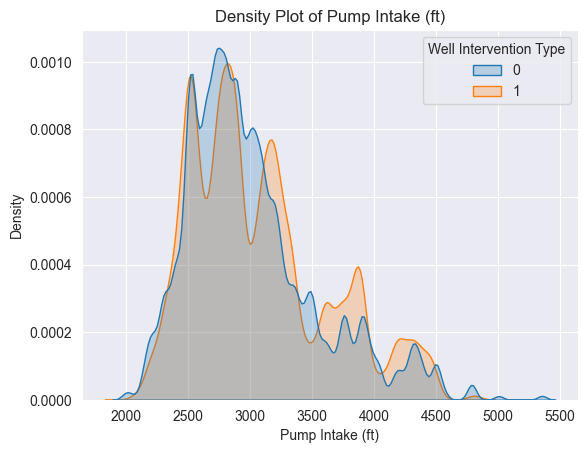

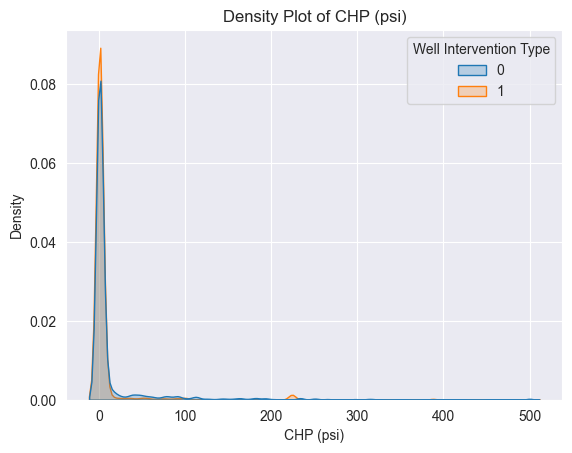

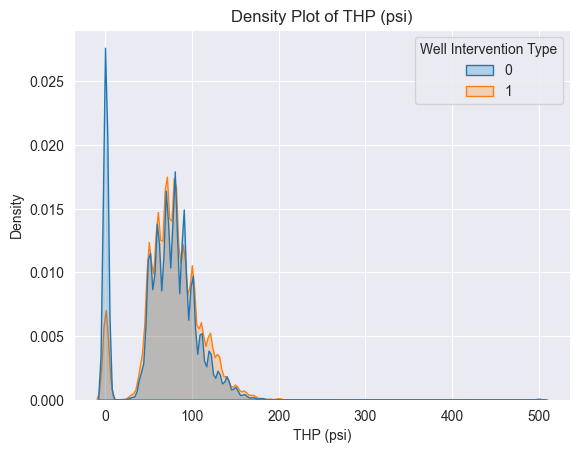

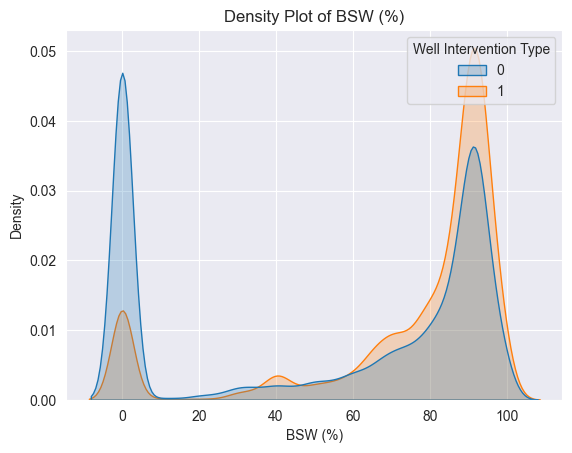

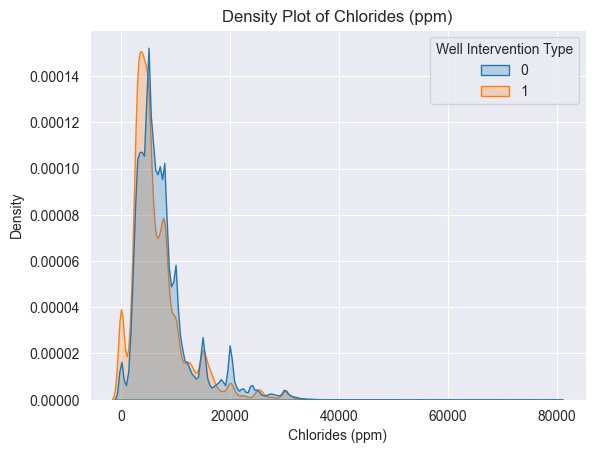

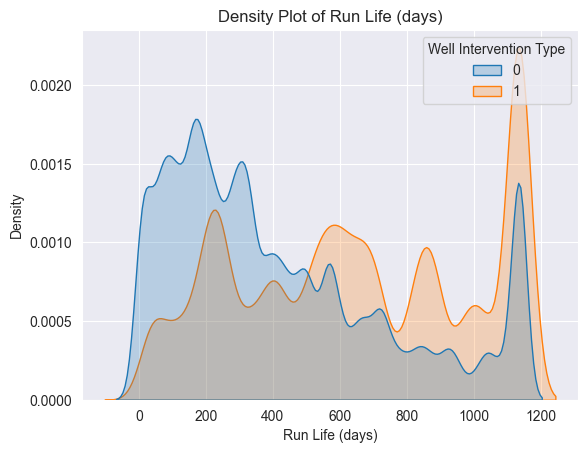

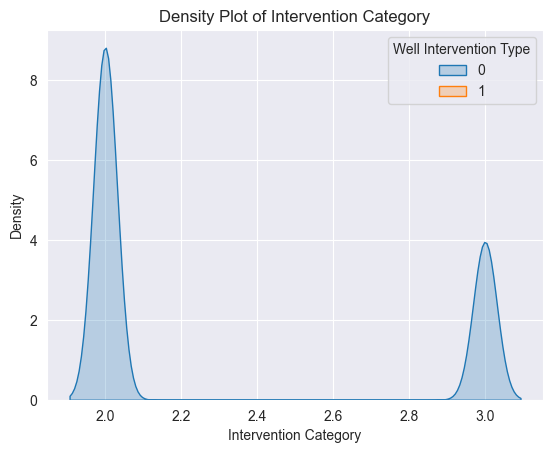

In [10]:
# Features to visualize
df_numeric = data.select_dtypes(include=[float, int])

if 'Well Intervention Type' not in data.columns:
    data = pd.concat([data, df_numeric['Well Intervention Type']], axis=1)

# Plot density plots for each feature
df_numeric = data.select_dtypes(include=[float, int])
for feature in df_numeric.columns:
    if feature != 'Well Intervention Type':
        plt.figure()
        sns.kdeplot(data=data, x=feature, hue='Well Intervention Type', common_norm=False, fill=True, warn_singular=False)
        plt.title(f'Density Plot of {feature}')
        plt.show()

# Insights and comments

We decided to include the Artificial Lift System in the evaluation of the machine learning model, and for that reason, we applied One-Hot techniques to convert it into a binary variable. Considering that there are 3 different types of ALS, they were grouped as follows according to the equipment configuration: ROD_PCP (requires a rod string for installation) and ESP (rod string installation-free).

Correlation matrix | Key observations:
Well Intervention Type has a moderate negative correlation with Intervention Category (-0.68), suggesting that certain types of interventions are associated with specific categories, even though Run Life (days) shows a low correlation 0.21 (positive correlation) the development of the ML model can generate important findings for this project.
Total Fluid Rate is strongly correlated with BSW (%) (0.67), suggesting that higher fluid rates are associated with higher BSW percentages.
Run Life shows a moderate positive correlation with Fluid Level (0.34) and THP (psi) (0.35), indicating these factors might be predictive of the run life of the wells.

# Imbalanced Data and Oversampling

In [11]:
X = data.drop(['Well Intervention Type', 'Well Name', 'START_DATE', 'Stop Date', 'Oil rate (bls)', 'Gas rate (scf)',
       'Water rate (bls)', 'Active String?', 'Rift Subsystem', 'Rift Component Primary', 'Rift Cause General', 'Intervention Category', 'String Status', 'Artificial_Lift_Type' ], axis=1)

y = data['Well Intervention Type']

In [12]:
counter = Counter(y)
print("Class distribution before resampling:", counter)
print(f"Shape of X before SMOTE: {X.shape}")
print(f"Shape of y before SMOTE: {y.shape}")

Class distribution before resampling: Counter({0: 714142, 1: 87653})
Shape of X before SMOTE: (801795, 9)
Shape of y before SMOTE: (801795,)


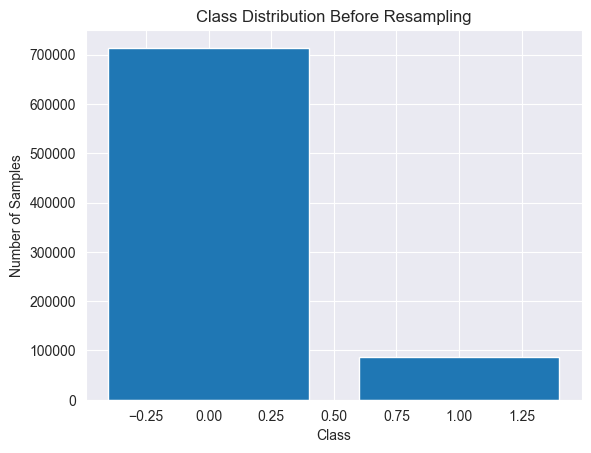

In [13]:
# Visualizing the data imbalance
plt.bar(counter.keys(), counter.values())
plt.title('Class Distribution Before Resampling')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

In [14]:
# Applying oversampling technique: SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [15]:
# Standardize features AFTER oversampling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

In [16]:
print(f"Shape of X_resampled: {X_resampled.shape}")
print(f"Shape of y_resampled: {y_resampled.shape}")

Shape of X_resampled: (1428284, 9)
Shape of y_resampled: (1428284,)


In [17]:
counter_resampled = Counter(y_resampled)
print("Class distribution after resampling:", counter_resampled)

Class distribution after resampling: Counter({0: 714142, 1: 714142})


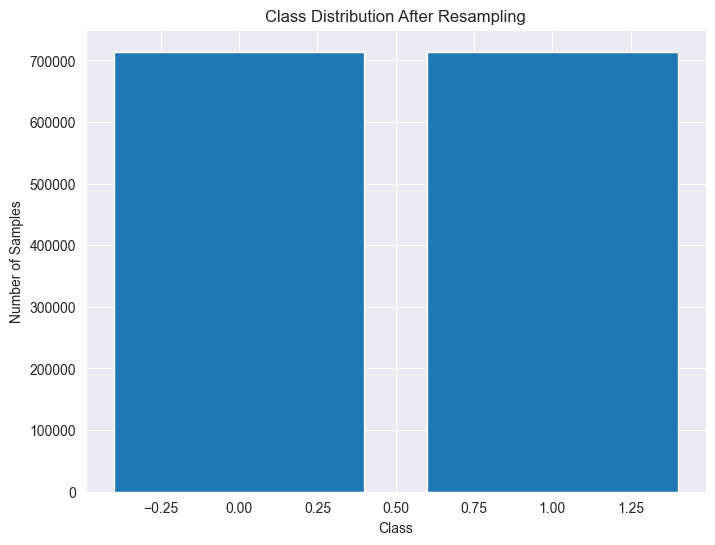

In [18]:
# Visualizing the data imbalance AFTER resampling
plt.figure(figsize=(8, 6))
plt.bar(counter_resampled.keys(), counter_resampled.values())
plt.title('Class Distribution After Resampling')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Insights and comments

After completing the Statistical Analysis and Data Visualization Report, we identified the poor correlations of the variables with 'Run Life (days)' and decided to change the target variable to Well Intervention Type. The development of the ML model includes this feature.

To address the data imbalance, SMOTE technique was performed by generating synthetic samples for the minority class, ensuring the model has sufficient data to learn from both classes effectively, thus improving performance and robustness. 

Note: random_state=42 to ensure reproducibility of results, allowing others to obtain the same resampled dataset and model outcomes

# Feature Engineering

In [19]:
# Feature selection using SelectKBest()
# Justification: Chi2 is chosen because it measures the dependence between categorical variables, making it suitable for our categorical target variable.

In [20]:
# 'Well Intervention Type' has defined as "target variable"

selector = SelectKBest(f_classif, k='all') 
X_new = selector.fit_transform(X_scaled, y_resampled)

In [21]:
# Calculated scores for all features (chi2 statistics)
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': selector.scores_,
    'p-Value': selector.pvalues_
})

In [22]:
# Sorting the features by Chi2 score
feature_scores_sorted = feature_scores.sort_values('Chi2 Score', ascending=False)
print(feature_scores_sorted)

                  Feature     Chi2 Score  p-Value
8         Run Life (days)  162966.079987      0.0
6                 BSW (%)  124812.284375      0.0
2        Fluid Level (ft)   90116.146159      0.0
5               THP (psi)   35611.060813      0.0
1  Total fluid rate (bls)   28380.135042      0.0
7         Chlorides (ppm)   15450.471585      0.0
4               CHP (psi)   14107.250297      0.0
0  Artificial Lift System   11803.828128      0.0
3        Pump Intake (ft)    4592.270212      0.0


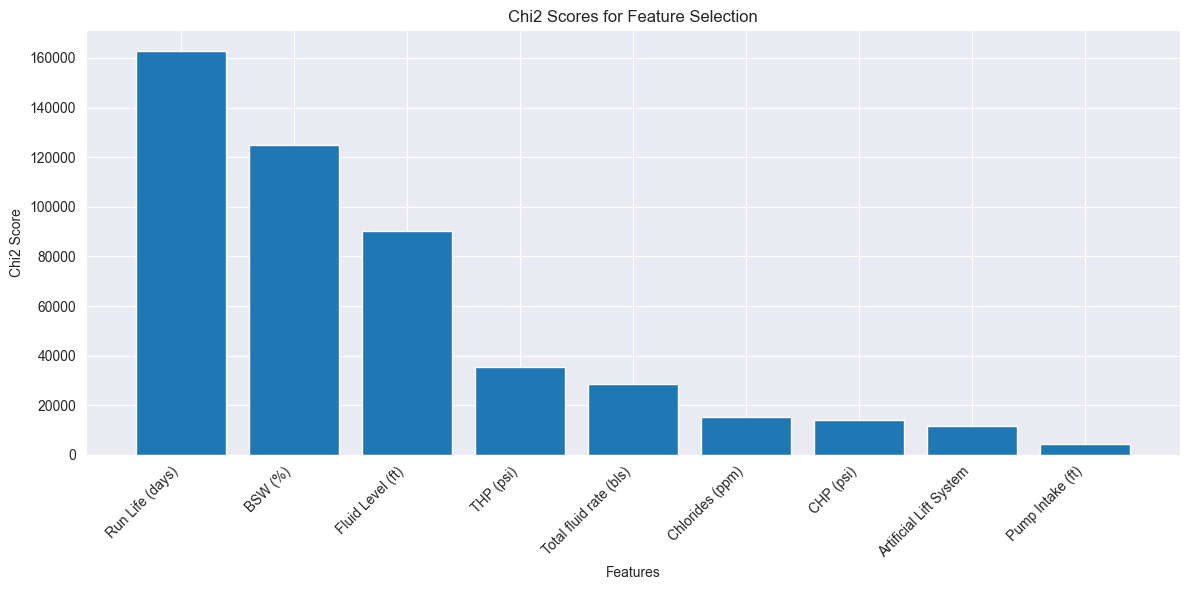

In [23]:
# Visualizing the chi2 scores
plt.figure(figsize=(12, 6))
plt.bar(feature_scores_sorted['Feature'], feature_scores_sorted['Chi2 Score'])
plt.xlabel('Features')
plt.ylabel('Chi2 Score')
plt.title('Chi2 Scores for Feature Selection')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
# Features with a statistically significant relationship with the target
alpha = 0.05  # Significance level
significant_features = feature_scores_sorted[feature_scores_sorted['p-Value'] < alpha]

print(f"\nSignificant features based on Chi2 test (alpha = {alpha}):")
print(significant_features)


Significant features based on Chi2 test (alpha = 0.05):
                  Feature     Chi2 Score  p-Value
8         Run Life (days)  162966.079987      0.0
6                 BSW (%)  124812.284375      0.0
2        Fluid Level (ft)   90116.146159      0.0
5               THP (psi)   35611.060813      0.0
1  Total fluid rate (bls)   28380.135042      0.0
7         Chlorides (ppm)   15450.471585      0.0
4               CHP (psi)   14107.250297      0.0
0  Artificial Lift System   11803.828128      0.0
3        Pump Intake (ft)    4592.270212      0.0


# Insights and comments

The output indicates that "Run Life (days)" has the highest Chi2 score, suggesting it has the strongest relationship with the target variable, followed by "BSW (%)" and "Fluid Level (ft). This finding is valuable as it aligns with the experience of the engineering personnel working in the field.

In [25]:
# Recursive Feature Elimination (RFE) was selected to iteratively remove the least important features based on a model's coefficients

In [26]:
# Creating the logistic regression model
log_reg = LogisticRegression(max_iter=500, solver='liblinear')

# Applying RFE
rfe = RFE(estimator=log_reg, n_features_to_select=5, step=1)
selected_features_rfe = rfe.fit_transform(X_scaled, y_resampled)

In [27]:
# Creating a DataFrame with the selected features
selected_features_rfe_df = pd.DataFrame(selected_features_rfe)

In [28]:
# Getting the names of the selected features
selected_features_rfe_names = X.columns[rfe.get_support()]
selected_features_rfe_df.columns = selected_features_rfe_names

# Displaying the DataFrame with selected features
print(selected_features_rfe_df.head())

   Total fluid rate (bls)  Fluid Level (ft)   BSW (%)  Chlorides (ppm)  \
0                0.099360          0.467011  0.081134         -0.22075   
1               -0.259289          0.467011  0.053404         -0.22075   
2                0.384001          0.467011  0.413890         -0.22075   
3               -0.987972          0.467011 -1.804484         -0.22075   
4                0.287223          0.467011  0.441620         -0.22075   

   Run Life (days)  
0         1.648192  
1         1.648192  
2         1.648192  
3         1.648192  
4         1.648192  


In [29]:
# The ranking_ attribute contains the feature ranking
feature_ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values(ascending=True)
print("Feature ranking:")
print(feature_ranking.head(10))

Feature ranking:
Total fluid rate (bls)    1
Fluid Level (ft)          1
BSW (%)                   1
Chlorides (ppm)           1
Run Life (days)           1
Pump Intake (ft)          2
Artificial Lift System    3
THP (psi)                 4
CHP (psi)                 5
dtype: int32


# Insights and comments

We used RFE with LogisticRegression as the estimator to select the top 5 features because it helps identify the most significant features: 

Feature ranking:
Total fluid rate (bls)    1
Fluid Level (ft)          1
BSW (%)                   1
Chlorides (ppm)           1
Run Life (days)           1

In [30]:
# We selected (PCA) for dimensionality reduction to transform the original features into a smaller set of uncorrelated components, capturing the most variance in the data. We used PCA due to capturing the most variance in the data with uncorrelated components and is computationally efficient.

In [31]:
# Standardize features before PCA 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Apply PCA
pca = PCA()  
X_pca = pca.fit_transform(X_scaled)

In [32]:
# Analyzing exp. variance to determine the number of components to keep
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

In [33]:
print("Explained variance ratio per component:")
print(explained_variance_ratio)
print("Cumulative explained variance ratio:")
print(cumulative_explained_variance)

Explained variance ratio per component:
[0.29464643 0.17534552 0.12215404 0.09930045 0.09463135 0.07895939
 0.0645583  0.03889451 0.03151001]
Cumulative explained variance ratio:
[0.29464643 0.46999195 0.59214599 0.69144643 0.78607778 0.86503718
 0.92959548 0.96848999 1.        ]


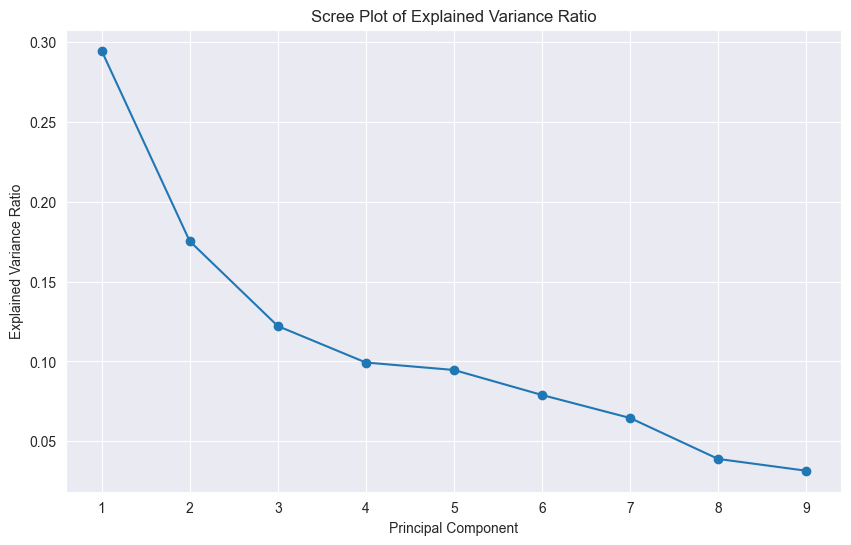

In [34]:
# Plotting exp variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Scree Plot of Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

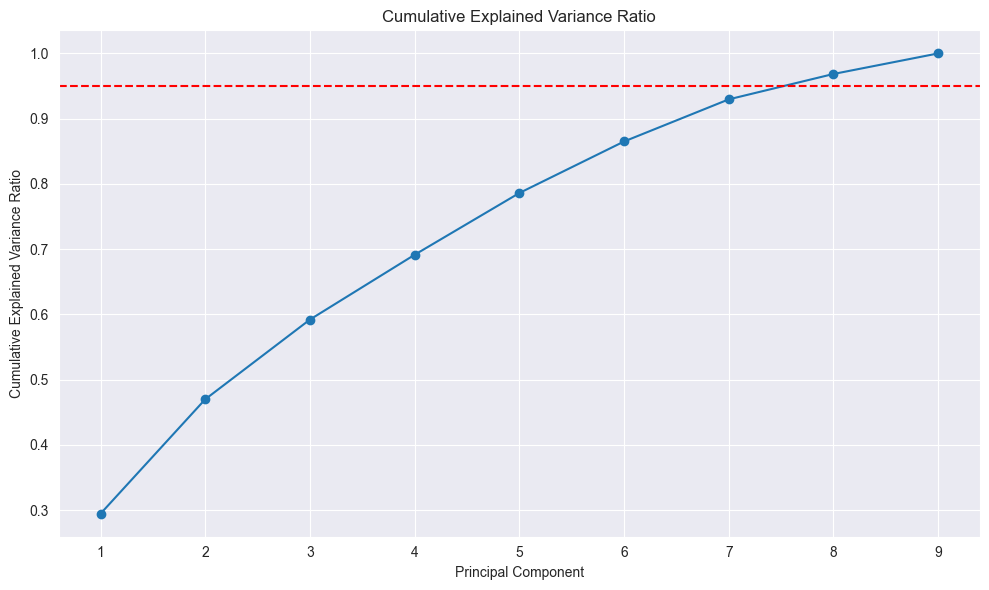

In [35]:
# Plotting exp variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [36]:
# Choosing the number of components

n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

Number of components to retain 95% variance: 8


In [37]:
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Insights and comments

Variance Ratio Analysis: after the first component and more gradually after the third component, indicating that the first few components capture most of the data's variability. This suggests that we can reduce the dimensionality of the dataset to 3. 

# Data Splitting (Training / Testing / Validation)

In [38]:
X = X_pca
y = y_resampled

# Split into train and test sets (70/30 split)
# Justification: We choose a 70/30 split to have sufficient data for training while leaving enough for testing. The StratifiedShuffleSplit ensures that the proportion of classes ('failure' and 'no_failure') is preserved in both sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Verify the class distribution in the training and test sets
print("Class distribution in the training set:")
print(pd.Series(y_train).value_counts(normalize=True))
print("Class distribution in the test set:")
print(pd.Series(y_test).value_counts(normalize=True))

# Size of the datasets
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Class distribution in the training set:
Well Intervention Type
0    0.5
1    0.5
Name: proportion, dtype: float64
Class distribution in the test set:
Well Intervention Type
0    0.5
1    0.5
Name: proportion, dtype: float64
Training set size: 999798
Test set size: 428486


In [39]:
# Split train set into train and validation sets (80/20 split of the train set)
# Justification: A validation set is created to tune hyperparameters and avoid overfitting. We use 20% of the training data for validation.

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify=y_train)

# Verify the class distribution in the training and test sets
print("Class distribution in the final training set:")
print(pd.Series(y_train_final).value_counts(normalize=True))
print("Class distribution in the validation set:")
print(pd.Series(y_val).value_counts(normalize=True))

# Size of the datasets
print(f"Final training set size: {X_train_final.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Class distribution in the final training set:
Well Intervention Type
0    0.5
1    0.5
Name: proportion, dtype: float64
Class distribution in the validation set:
Well Intervention Type
0    0.5
1    0.5
Name: proportion, dtype: float64
Final training set size: 799838
Validation set size: 199960


# Data Modeling

## Decision Tree

In [40]:
# Modeling Algorithms - Decision Tree

In [41]:
# Defining pipeline / cross-validation 
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=8)),
    ('dt', DecisionTreeClassifier())
])

In [42]:
# Hyperparameter Tuning
param_grid = {
    'dt__max_depth': [3, 5, 10, 20],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}

In [43]:
# GridSearchCV with Cross-validation with 5 folders
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_final, y_train_final)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=8)),
                                       ('dt', DecisionTreeClassifier())]),
             param_grid={'dt__max_depth': [3, 5, 10, 20],
                         'dt__min_samples_leaf': [1, 2, 4],
                         'dt__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [44]:
# Best model after hyperparameter tuning
best_model = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")

Best parameters found: {'dt__max_depth': 20, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}


In [45]:
# Predictions on the Test Set
y_pred = best_model.predict(X_val)

In [46]:
# Performance Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9445
Precision: 0.9360
Recall: 0.9542
F1 Score: 0.9450


In [47]:
# Prediction probabilities for ROC and AUC calculation
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

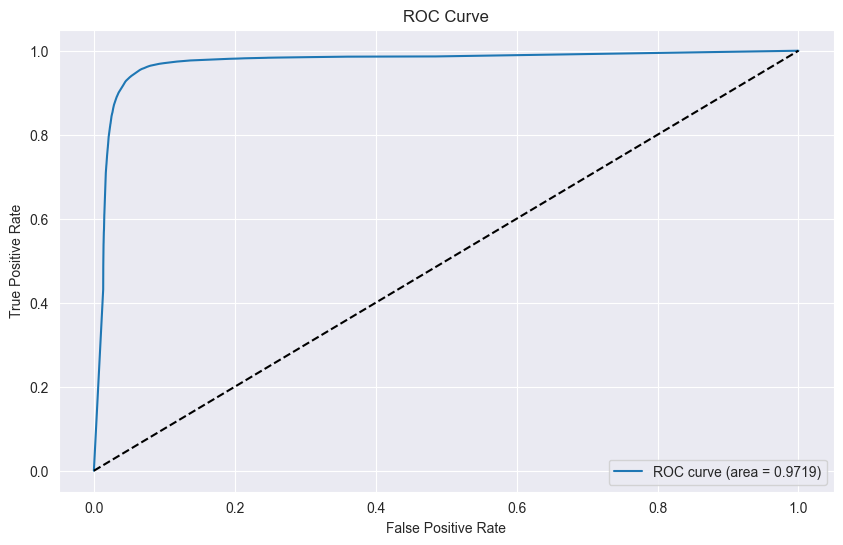

In [48]:
# Plotting ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

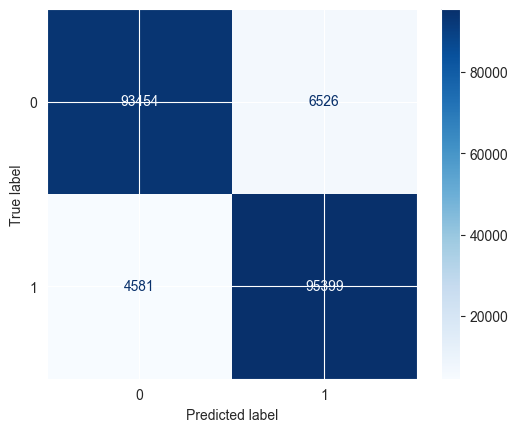

In [49]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [50]:
# Learning Curve (Underfitting/Overfitting Analysis)
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_final, y_train_final, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

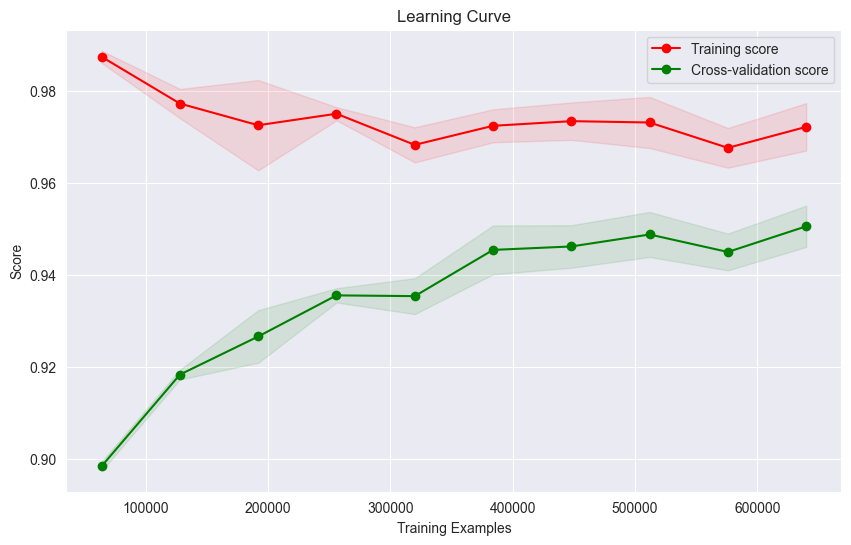

In [51]:
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()